## About

### General
Working on a dataset of offering prices at a local Starbucks and Saxby's (a local coffee shop). Scraped the data via a Grubhub API endpoint, see [GrubhubDataCleaning](https://github.com/patriots1/GrubhubDataCleaning). 

### Aim
The aim of this analysis is to see how Saxby's and Starbuck's prices match up to each other. 

### Overview of process
Did moderate cleaning of data to structure for K-Means Clustering, and general data analysis, which the first half of this notebook is about. Create a Swarmplot before K-Means Clustering for prelimenary statistical analysis, and implement K-Means Clustering for an ML approach to this analysis. 

## Part 1: Initializing Data

#### Importing Dependencies

In [1]:
import pandas as pd
import json
from json import encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#### Import data from JSON file and store it in a Pandas DataFrame

In [2]:
# import data from cleaned json file
file = open('cleaned_input_file1.json')

In [3]:
# convert the input file to a dictionary
data_ls = json.load(file)

In [4]:
# look at the elements of the list
data_ls[0]

{'shop_name': 'Starbucks',
 'location': ['42.3399145', '-71.0887372'],
 'dish_name': 'Caffe Americano',
 'dish_description': 'Espresso shots topped with hot water create a light layer of crema culminating in this wonderfully rich cup with depth and nuance. Pro tip: For an additional boost, ask to try this with an extra shot.',
 'dish_image_link': 'https://media-cdn.grubhub.com/image/upload/w_1.46,h_1,c_lpad/tapingo-shops-assets/media/images/941/bcd/a4f817112069a2a985978813eeef447702',
 'dish_price': 3.45,
 'dish_category': 'Hot Coffees'}

In [5]:
# convert the dictionary to a panda dataframe
data_df = pd.DataFrame(data_ls)

#### Look at the various statistical values for numerical columns of this DataFrame

In [6]:
data_df.describe()

,dish_price
count,260.000000
mean,4.292192
std,1.717147
min,0.990000
25%,3.250000
50%,4.450000
75%,5.005000
max,14.000000


## Part 2: Clean data

#### Start cleaning data for analysis

#### Split the DataFrame into two distinct DataFrames - one for Starbucks, another for Saxby's

In [7]:
dish_category_DataFrame = data_df.loc[:, ['shop_name', 'dish_category']]
dish_category_DataFrame_starbucks = dish_category_DataFrame.loc[dish_category_DataFrame['shop_name'] == 'Starbucks', :  ]
dish_category_DataFrame_saxbys = dish_category_DataFrame.loc[dish_category_DataFrame['shop_name'] == 'Saxby', :  ]
starbucks_dc = dish_category_DataFrame_starbucks.to_dict()
saxbys_dc = dish_category_DataFrame_saxbys.to_dict()

#### Look at the various statistical values for numerical columns of the Starbucks DataFrame.

In [8]:
dish_category_DataFrame_starbucks.describe()

,shop_name,dish_category
count,166,166
unique,1,12
top,Starbucks,Cold Drinks
freq,166,27


#### Look at the various statistical values for numerical columns of the Saxby's DataFrame.

In [9]:
dish_category_DataFrame_saxbys.describe()

,shop_name,dish_category
count,94,94
unique,1,14
top,Saxby,Teas & Steamers
freq,94,16


Referring to **< above 2 tables >**
#### Big difference: Starbucks has a much larger menu than Saxby's
#### Solution: Normalize the prices of these dishes

Referring to the **< below block >**
#### Find all the unique dish categories for Starbucks and Saxbys

In [10]:
# check the different dish categories (combine both coffee shops's dish categories into one)
starbucks_categories_ls = []
saxbys_categories_ls = []

starbucks_dc.pop('shop_name', None)
saxbys_dc.pop('shop_name', None)

starbucks_unique_ls = []
saxby_unique_ls = []

for key in starbucks_dc['dish_category']:
    if starbucks_dc['dish_category'][key] not in starbucks_unique_ls:
        starbucks_unique_ls.append(starbucks_dc['dish_category'][key])

for key in saxbys_dc['dish_category']:
    if saxbys_dc['dish_category'][key] not in saxby_unique_ls:
        saxby_unique_ls.append(saxbys_dc['dish_category'][key])

# print the current dish categories for both places
print(f'Starbucks: {starbucks_unique_ls} \n')
print(f'Saxby: {saxby_unique_ls} \n')

Starbucks: ['Hot Coffees', 'Hot Teas', 'Hot Drinks', 'Frappuccino Blended Beverages', 'Cold Coffees', 'Cold Drinks', 'Iced Teas', 'Hot Breakfast', 'Oatmeal & Yogurt', 'Bakery', 'Lunch', 'Snacks & Sweets'] 

Saxby: ["The Saxby's Hall of Greats", 'Energy', 'Cold Brew Collection', 'Hot Coffee', 'Espresso Drinks', 'Teas & Steamers', 'Meet Your Matcha', 'Smoothies', 'Breakfast All Day', 'Grilled Cheese', 'Bakery', 'Grab & Go Food', 'Grab & Go Drinks', 'Coffee For Home'] 



#### Print out all duplicate dishes in Saxby's

In [11]:
# checking to see whether saxby's dish categories have some repeat dishes, isolate them to see what dishes they are.

dish_category_series_saxbys = data_df.loc[dish_category_DataFrame['shop_name'] == 'Saxby', : ]
dish_category_series_saxbys_clean = dish_category_series_saxbys.loc[ :, ['dish_category', 'dish_name']]
dict = dish_category_series_saxbys_clean.to_dict()

repeats_in_saxby_items = []
for key in dict['dish_name']:
    if dict['dish_name'][key] not in repeats_in_saxby_items:
        repeats_in_saxby_items.append({
            'dish_category': dict['dish_category'][key],
            'dish_name': dict['dish_name'][key],
        })

cleaned_repeats_saxby = {}

for index in repeats_in_saxby_items:
    if index['dish_name'] not in cleaned_repeats_saxby:
        cleaned_repeats_saxby[index['dish_name']] = [index['dish_category']]
    else:
        cleaned_repeats_saxby[index['dish_name']].append(index['dish_category'])

final_cleaned_saxby = {}

for key in cleaned_repeats_saxby:
    if len(cleaned_repeats_saxby[key]) != 1:
        final_cleaned_saxby[key] = cleaned_repeats_saxby[key]

for key, value in final_cleaned_saxby.items():
    print(f'{key}: {value}')
    print()

test_df = data_df.loc[data_df['dish_category'] == 'Energy' ,:]
shape_energy = test_df.shape
print(f'Energy {shape_energy}')

test_df = data_df.loc[data_df['dish_category'] == 'Meet Your Matcha' ,:]
shape_matcha = test_df.shape
print(f'Matcha {shape_matcha}')

test_df = data_df.loc[data_df['dish_category'] == 'Breakfast All Day' ,:]
shape_bkfast = test_df.shape
print(f'Breakfast {shape_bkfast}')

test_df = data_df.loc[data_df['dish_category'] == 'Grilled Cheese' ,:]
shape_gc = test_df.shape
print(f'Grilled Cheese {shape_gc}')

test_df = data_df.loc[data_df['dish_category'] == "The Saxby's Hall of Greats" ,:]
shape_greats = test_df.shape
print(f'The Saxby\'s Hall of Greats {shape_greats}')

# Conclusion - 'Energy,' 'The Saxby's Hall of Greats' and 'Meet Your Matcha' are redundant, can remove these categories.
# Breakfast Grilled Three Cheese - will remove as it is in both. 

Vanilla Bean Cold Brew: ["The Saxby's Hall of Greats", 'Cold Brew Collection']

Strawberry Rush Energy Drink: ["The Saxby's Hall of Greats", 'Energy', 'Teas & Steamers']

Buffalo Chicken Grilled Cheese: ["The Saxby's Hall of Greats", 'Grilled Cheese']

Breakfast Burrito: ["The Saxby's Hall of Greats", 'Breakfast All Day']

French Toast Muffin: ["The Saxby's Hall of Greats", 'Bakery']

Peach Rush Energy Drink: ['Energy', 'Teas & Steamers']

OG Rush Energy Drink: ['Energy', 'Teas & Steamers']

Matcha Latte: ['Teas & Steamers', 'Meet Your Matcha']

Iced Matcha Latte: ['Teas & Steamers', 'Meet Your Matcha']

Breakfast Grilled Three Cheese: ['Breakfast All Day', 'Grilled Cheese']

Energy (3, 7)
Matcha (2, 7)
Breakfast (6, 7)
Grilled Cheese (7, 7)
The Saxby's Hall of Greats (5, 7)


#### Print out all duplicate dishes in Starbucks

In [12]:
# checking to see whether starbuck's dish categories have some repeat dishes, isolate them to see what dishes they are.

dish_category_series_starbucks = data_df.loc[dish_category_DataFrame['shop_name'] == 'Starbucks', : ]
dish_category_series_starbucks_clean = dish_category_series_starbucks.loc[ :, ['dish_category', 'dish_name']]
dict = dish_category_series_starbucks_clean.to_dict()

repeats_in_starbucks_items = []
for key in dict['dish_name']:
    if dict['dish_name'][key] not in repeats_in_starbucks_items:
        repeats_in_starbucks_items.append({
            'dish_category': dict['dish_category'][key],
            'dish_name': dict['dish_name'][key],
        })

cleaned_repeats_starbucks = {}

for index in repeats_in_starbucks_items:
    if index['dish_name'] not in cleaned_repeats_starbucks:
        cleaned_repeats_starbucks[index['dish_name']] = [index['dish_category']]
    else:
        cleaned_repeats_starbucks[index['dish_name']].append(index['dish_category'])

final_cleaned_starbucks = {}

for key in cleaned_repeats_starbucks:
    if len(cleaned_repeats_starbucks[key]) != 1:
        final_cleaned_starbucks[key] = cleaned_repeats_starbucks[key]

for key, value in final_cleaned_starbucks.items():
    print(f'{key}: {value}')
    print()

test_df = data_df.loc[data_df['dish_category'] == "Hot Breakfast" ,:]
shape_energy = test_df.shape
print(f'Hot Breakfast {shape_energy}')

test_df = data_df.loc[data_df['dish_category'] == 'Bakery' ,:]
shape_matcha = test_df.shape
print(f'Bakery {shape_matcha}')

test_df = data_df.loc[data_df['dish_category'] == 'Lunch' ,:]
shape_bkfast = test_df.shape
print(f'Lunch {shape_bkfast}')

test_df = data_df.loc[data_df['dish_category'] == 'Snacks & Sweets' ,:]
shape_gc = test_df.shape
print(f'Snacks & Sweets {shape_gc}')

# Conclusion - only one repeat item, Avacado Spread
# Avacado Spread - will remove as it is in all.

Avocado Spread: ['Hot Breakfast', 'Bakery', 'Lunch', 'Snacks & Sweets']

Hot Breakfast (12, 7)
Bakery (25, 7)
Lunch (9, 7)
Snacks & Sweets (5, 7)


#### Remove Saxby's duplicates from DataFrame

In [13]:
#change DataFrame
#take care of Saxby's products
data_clean = data_df.loc[
    (data_df['dish_category'] != 'Energy') & 
    (data_df['dish_category'] != 'Meet Your Matcha') &
    (data_df['dish_name'] != 'Breakfast Grilled Three Cheese') &
    (data_df['dish_category'] != "The Saxby's Hall of Greats")]

data_df = data_clean

#### Remove Starbuck's duplicates from DataFrame

In [14]:
#take care of Starbuck's products
data_clean = data_df.loc[
    (data_df['dish_name'] != 'Avocado Spread')]

data_df = data_clean

#### Combine both shop's dish categories into one category

In [15]:
#combine both coffee shop's categories into one

Starbucks = ['Hot Coffees', 'Hot Teas', 'Hot Drinks', 'Frappuccino Blended Beverages', 
           'Cold Coffees', 'Cold Drinks', 'Iced Teas', 'Hot Breakfast', 'Oatmeal & Yogurt', 'Bakery', 'Lunch', 'Snacks & Sweets'] 

Saxby =  ['Cold Brew Collection', 'Hot Coffee', 'Espresso Drinks', 'Teas & Steamers', 
       'Smoothies', 'Breakfast All Day', 'Grilled Cheese', 'Bakery', 
       'Grab & Go Food', 'Grab & Go Drinks', 'Coffee For Home'] 

mapping_dict = {
    'Hot Coffees': 'Hot Coffees',
    'Hot Coffee': 'Hot Coffees',
    'Espresso Drinks': 'Hot Coffees',
    'Cold Coffees': 'Cold Coffees',
    'Cold Brew Collection': 'Cold Coffees',
    'Hot Drinks': 'Hot Drinks',
    'Cold Drinks': 'Cold Drinks',
    'Grab & Go Drinks': 'Cold Drinks', 
    'Teas & Steamers': 'Teas & Herbal Beverages',
    'Hot Teas': 'Teas & Herbal Beverages',
    'Iced Teas': 'Teas & Herbal Beverages',
    'Frappuccino Blended Beverages': 'Frappuccino & Blended Beverages',
    'Smoothies': 'Smoothies',
    'Breakfast All Day': 'Breakfast Items',
    'Hot Breakfast': 'Breakfast Items',
    'Bakery': 'Bakery Items',
    'Snacks & Sweets': 'Snacks & Sweets',
    'Oatmeal & Yogurt': 'Snacks & Sweets',
    'Lunch': 'Lunch Items',
    'Grab & Go Food': 'Lunch Items',
    'Grilled Cheese': 'Lunch Items',
    'Coffee For Home': 'Coffee For Home'
}

data_df['dish_category_unified'] = data_df['dish_category'].replace(mapping_dict)

data_df.head()



,shop_name,location,dish_name,dish_description,dish_image_link,dish_price,dish_category,dish_category_unified
0,Starbucks,"[42.3399145, -71.0887372]",Caffe Americano,Espresso shots topped with hot water create a ...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees
1,Starbucks,"[42.3399145, -71.0887372]",Caffe Misto,A 1-to-1 combination of fresh-brewed coffee an...,https://media-cdn.grubhub.com/image/upload/w_1...,4.25,Hot Coffees,Hot Coffees
2,Starbucks,"[42.3399145, -71.0887372]",Blonde Roast Coffee,"Lightly roasted coffee that's soft, mellow and...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees
3,Starbucks,"[42.3399145, -71.0887372]",Featured Starbucks Dark Roast Coffee,"This full-bodied dark roast coffee with bold, ...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees
4,Starbucks,"[42.3399145, -71.0887372]",Pike Place Roast Coffee,From our first store in Seattle's Pike Place M...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees


#### Checking for null values in DataFrame 

In [16]:
# check for null values in the dataframe
# note - there were null prices, but were removed from json file inadvently (was fixing format of prices).
print(data_df.isnull().sum())

shop_name                0
location                 0
dish_name                0
dish_description         0
dish_image_link          0
dish_price               0
dish_category            0
dish_category_unified    0
dtype: int64


In [17]:
# consequence of the messup :(
df_clean = data_df

## Part 3: Exploratory Data Analysis & Cleaning for K-Means Cluster

#### Create a Swarmplot to check the distribution

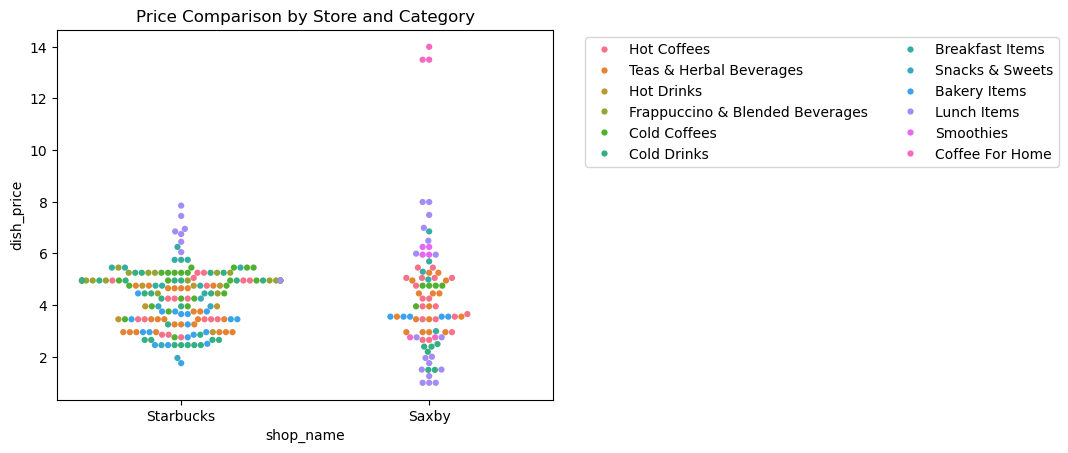

In [18]:
# prices per category (plot)
# use a swarmplot to see the price comparision per category without overlap. 
sns.swarmplot(data=data_df, x='shop_name', y='dish_price', hue='dish_category_unified', size = 4.5)
plt.title("Price Comparison by Store and Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.show()

Referring to the **< above graph >**
#### Many of Starbucks items are centered around 4 to 6 dollars, while Saxby's is spread around the graph.
#### The outliers in Saxby's graph will be removed.

Referring to the **< below block >**
#### Remove outliers from Saxby's 

In [19]:
df_price = df_clean.loc[df_clean['dish_price'] < 10]
df_clean = df_price

#### Add numerical representation to dish categories by LabelCoding them

In [20]:
# Convert dish_category_unified to numerical values using LabelEncoder
# For K mean clustering, need numerical representation of catagorical data, hence adding this. 
le = LabelEncoder()
df_clean.loc[:, 'dish_category_unified_encoded'] = le.fit_transform(df_clean['dish_category_unified'])

/var/folders/mk/xn54yytj4_7gvhlx2n3v13gh0000gn/T/ipykernel_90108/3347007164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'dish_category_unified_encoded'] = le.fit_transform(df_clean['dish_category_unified'])


#### Normalize price values for balancing influence of both coffee shops

In [21]:
# Normalizing (shrinking the range) of prices to allow for better k mean clustering.
scaler = StandardScaler()
df_clean['price_normalized'] = scaler.fit_transform(df_clean[['dish_price']])
#df_clean['price_normalized'] = 
# data_df.groupby('shop_name')['dish_price'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

/var/folders/mk/xn54yytj4_7gvhlx2n3v13gh0000gn/T/ipykernel_90108/191394852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_normalized'] = scaler.fit_transform(df_clean[['dish_price']])


#### Display first few values of DataFrame for reference

In [22]:
df_clean.head()

,shop_name,location,dish_name,dish_description,dish_image_link,dish_price,dish_category,dish_category_unified,dish_category_unified_encoded,price_normalized
0,Starbucks,"[42.3399145, -71.0887372]",Caffe Americano,Espresso shots topped with hot water create a ...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840
1,Starbucks,"[42.3399145, -71.0887372]",Caffe Misto,A 1-to-1 combination of fresh-brewed coffee an...,https://media-cdn.grubhub.com/image/upload/w_1...,4.25,Hot Coffees,Hot Coffees,6,0.052483
2,Starbucks,"[42.3399145, -71.0887372]",Blonde Roast Coffee,"Lightly roasted coffee that's soft, mellow and...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840
3,Starbucks,"[42.3399145, -71.0887372]",Featured Starbucks Dark Roast Coffee,"This full-bodied dark roast coffee with bold, ...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840
4,Starbucks,"[42.3399145, -71.0887372]",Pike Place Roast Coffee,From our first store in Seattle's Pike Place M...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840


## Part 4: K-Means Cluster

#### Find the optimal amount of kernels for this scenario (using elbow method)

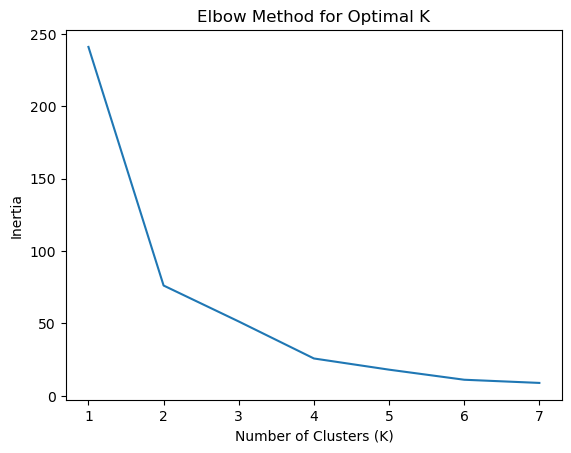

In [23]:
# apply k-means clustering (use dish_price to create clusters)
# create a list to store all intertia
# an inertia is the sum of squared distances from each point to its clustoid (the nearest cluster)
inertia = []
# check for best fit between 1 and 8 clusters.
for k in range(1, 8):
    # creates the KMeans object for k clusters.
    kmeans = KMeans(n_clusters=k, random_state=42)
    # fit the KMeans object to the priced_normalized column.
    kmeans.fit(df_clean[['price_normalized']])
    # add resulting inertia to the list.
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.plot(range(1, 8), inertia)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

#### Use 4 kernels as the amount of kernels for K-Means Cluster
#### Create the model, fit the model to 'price_normalized' column, predict kernels from this and add it to 'cluster' column

In [24]:
# above graph shows the greatest change ('elblow') at 3, so we will use 3 clusters
optimal_k = 3
# run the KMeans algorithm for 3 clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(df_clean[['price_normalized']])

/var/folders/mk/xn54yytj4_7gvhlx2n3v13gh0000gn/T/ipykernel_90108/2519185716.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cluster'] = kmeans.fit_predict(df_clean[['price_normalized']])


#### Display first few values of current DataFrame

In [25]:
df_clean.head()

,shop_name,location,dish_name,dish_description,dish_image_link,dish_price,dish_category,dish_category_unified,dish_category_unified_encoded,price_normalized,cluster
0,Starbucks,"[42.3399145, -71.0887372]",Caffe Americano,Espresso shots topped with hot water create a ...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840,2
1,Starbucks,"[42.3399145, -71.0887372]",Caffe Misto,A 1-to-1 combination of fresh-brewed coffee an...,https://media-cdn.grubhub.com/image/upload/w_1...,4.25,Hot Coffees,Hot Coffees,6,0.052483,2
2,Starbucks,"[42.3399145, -71.0887372]",Blonde Roast Coffee,"Lightly roasted coffee that's soft, mellow and...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840,2
3,Starbucks,"[42.3399145, -71.0887372]",Featured Starbucks Dark Roast Coffee,"This full-bodied dark roast coffee with bold, ...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840,2
4,Starbucks,"[42.3399145, -71.0887372]",Pike Place Roast Coffee,From our first store in Seattle's Pike Place M...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.544840,2


#### Textual representation of the K-Means Cluster results

In [29]:
numeric_columns = ['dish_price', 'dish_category_unified_encoded', 'price_normalized']
cluster_summary = df_clean.groupby(['cluster', 'shop_name'])[numeric_columns].size()
print(cluster_summary)
cluster_summary = df_clean.groupby(['cluster', 'shop_name'])[numeric_columns].mean()
print(cluster_summary)

cluster  shop_name
0        Saxby        30
         Starbucks    79
1        Saxby        27
         Starbucks    33
2        Saxby        22
         Starbucks    50
dtype: int64
                   dish_price  dish_category_unified_encoded  price_normalized
cluster shop_name                                                             
0       Saxby        5.712000                       6.466667          1.144090
        Starbucks    5.237342                       4.962025          0.789685
1       Saxby        2.200000                       6.629630         -1.478157
        Starbucks    2.681818                       5.000000         -1.118406
2       Saxby        3.795455                       6.318182         -0.286905
        Starbucks    3.816000                       5.300000         -0.271565


#### Graphical representation of the K-Means Cluster results

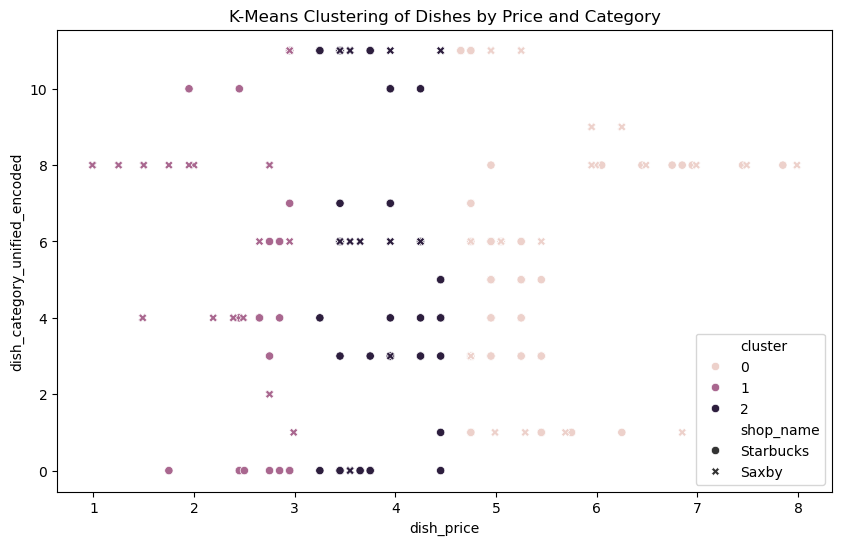

In [27]:
import seaborn as sns

# Scatter plot showing clusters by price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='dish_price', y='dish_category_unified_encoded', hue='cluster', style='shop_name')
plt.title('K-Means Clustering of Dishes by Price and Category')
plt.show()

## Part 5: Takeaways

* Cluster 0 has a relatively higher normalized price (around 1 STDs) for both coffee shops. This helps me conclude that all the dishes in this cluster are aimed towards a more wealthy clientele.
* Saxby's has a higher dish price for Cluster 0, while Starbucks has twice the amount of dishes targeting wealthy clientele. I believe that both these coffee shops equally cater to wealthy clientele, but Saxby's mean price in this category is higher due to their lower amount of offerings.
* Cluster 1 has a relatively lower normalized price (Starbucks: -0.75 STD, Saxby: -1.5 STD) for both coffee shops. The lower STD for Saxby's suggests that their offerings  are more focused to the richer clientele compared to Starbucks. Starbucks also doesn't focus much in this field, as they only have 33 offerings in this cluster, lower than the 79 and 50 in the other clusters.
* Cluster 2 is in the middle of Cluster 0 and 1, with having a STD between -0.25 and -0.3. This category is pretty consistent in regards to both coffee shops, so I don't have many observations to take note of. 